# 1.1 Data Cleaning — Python (paso a paso)
# Carga del archivo desde la carpeta input

In [126]:
import pandas as pd
import numpy as np
import os

# 0) Cargar datos
# Cambia la ruta al path exacto de tu repo: input/processed.cleveland.data

In [127]:
# Ruta del directorio que quieres establecer
ruta = r"C:/Users/ASUS/OneDrive - Universidad del Pacífico/Tareas Data Science/Decision_Trees/Python/"  # <- cambia esta ruta según tu caso

# Cambiar el directorio de trabajo
os.chdir(ruta)


# Si el archivo está en la misma carpeta que tu notebook:
# df = pd.read_csv("processed.cleveland.data", header=None)
df = pd.read_csv("input/processed.cleveland.data", header=None)
print(df.head())


     0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0


# 1) Renombrar variables

In [128]:
cols_order = [
    'age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'
]
df.columns = cols_order

# 2) Reemplazar los “?” por NaN y convertir a numérico

In [129]:
df = df.replace('?', np.nan)
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except Exception:
        pass


# 3) Eliminar filas con valores faltantes

In [130]:
df = df.dropna().reset_index(drop=True)

# 4) Especificar variables categóricas

In [131]:
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

for c in cat_cols:
    df[c] = df[c].astype('category')


# 5) Crear variable binaria y (1 = tiene enfermedad)

In [132]:
df['y'] = (df['hd'] > 0).astype(int)

# 6) Crear variables dummy

In [133]:
df_dum = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 7) Separar X e y

In [134]:
X = df_dum.drop(columns=['hd', 'y'])
y = df_dum['y']

# 8) Guardar archivos limpios

In [135]:
#df_dum.to_csv("output/heart_clean_with_dummies.csv", index=False)
X.to_csv("output/X_features.csv", index=False)
y.to_csv("output/y_binary.csv", index=False)

In [136]:
df_dum.head(10)

,age,restbp,chol,thalach,oldpeak,hd,y,sex_1.0,cp_2.0,cp_3.0,...,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,63.0,145.0,233.0,150.0,2.3,0,0,True,False,False,...,False,True,False,False,True,False,False,False,True,False
1,67.0,160.0,286.0,108.0,1.5,2,1,True,False,False,...,False,True,True,True,False,False,False,True,False,False
2,67.0,120.0,229.0,129.0,2.6,1,1,True,False,False,...,False,True,True,True,False,False,True,False,False,True
3,37.0,130.0,250.0,187.0,3.5,0,0,True,False,True,...,False,False,False,False,True,False,False,False,False,False
4,41.0,130.0,204.0,172.0,1.4,0,0,False,True,False,...,False,True,False,False,False,False,False,False,False,False
5,56.0,120.0,236.0,178.0,0.8,0,0,True,True,False,...,False,False,False,False,False,False,False,False,False,False
6,62.0,140.0,268.0,160.0,3.6,3,1,False,False,False,...,False,True,False,False,True,False,True,False,False,False
7,57.0,120.0,354.0,163.0,0.6,0,0,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8,63.0,130.0,254.0,147.0,1.4,2,1,True,False,False,...,False,True,False,True,False,True,False,False,False,True
9,53.0,140.0,203.0,155.0,3.1,1,1,True,False,False,...,False,True,True,False,True,False,False,False,False,True


# 9) Resumen

In [137]:
print("Filas finales:", df_dum.shape[0])
print("Columnas finales:", df_dum.shape[1])
print("Proporción de y=1:", y.mean().round(3))
print("Primeras columnas de X:", list(X.columns[:10]))

Filas finales: 297
Columnas finales: 22
Proporción de y=1: 0.461
Primeras columnas de X: ['age', 'restbp', 'chol', 'thalach', 'oldpeak', 'sex_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'fbs_1.0']


In [138]:
df = df.dropna().reset_index(drop=True)

# Mostrar resumen del DataFrame limpio
print("Tamaño después de dropna:", df.shape)
df.head()

Tamaño después de dropna: (297, 15)


,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd,y
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


# 1.2 — Árbol de clasificación con CV de ccp_alpha (paso a paso)
# Requiere: X, y (de la sección 1.1). Si no existen, los carga desde /output.

In [139]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score
)


# 0) Cargar X,y si no están en memoria (usa tus archivos de la sección 1.1)

In [140]:
if 'X' not in globals() or 'y' not in globals():
    X = pd.read_csv("output/X_features.csv")
    y = pd.read_csv("output/y_binary.csv").squeeze("columns")  # serie 1D

os.makedirs("output", exist_ok=True)

# 1) Split train/test y árbol base (random_state=123)

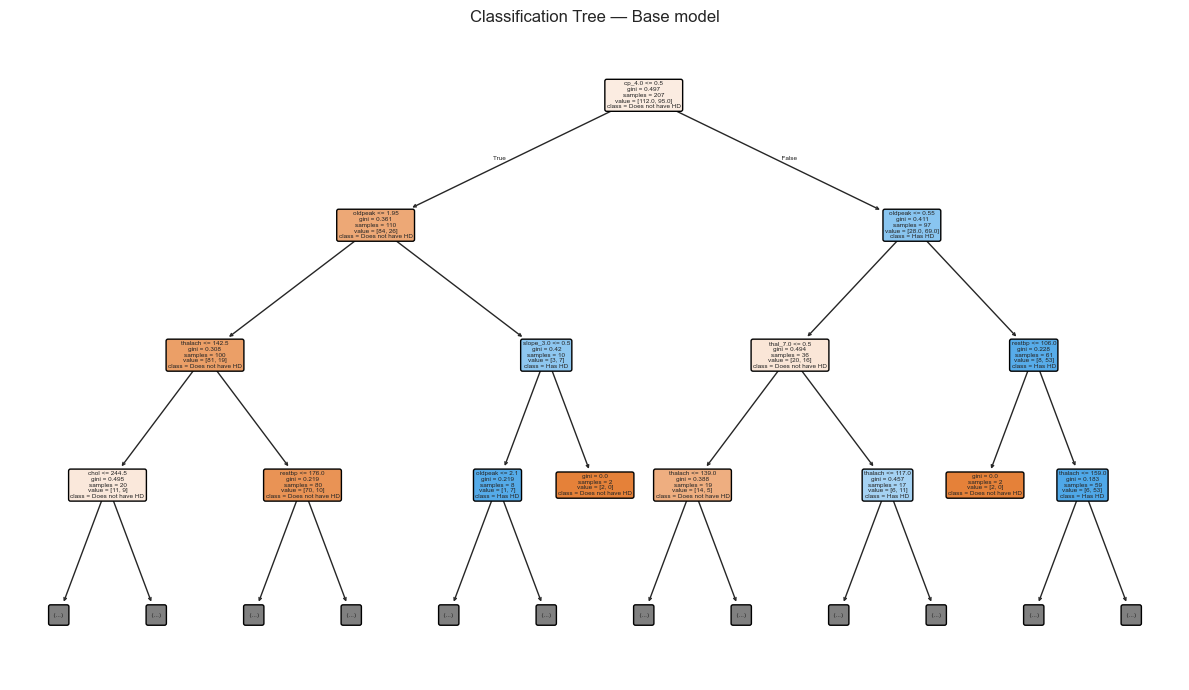

In [141]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=123
)

tree_base = DecisionTreeClassifier(random_state=123)
tree_base.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
plot_tree(
    tree_base,
    feature_names=X.columns.tolist(),
    class_names=["Does not have HD", "Has HD"],
    filled=True, rounded=True, max_depth=3  # recorta la vista para legibilidad
)
plt.title("Classification Tree — Base model")
plt.tight_layout()
plt.savefig("output/tree_base_PY.png", dpi=150)
plt.show()
plt.close()

# Matriz de confusión del modelo base 

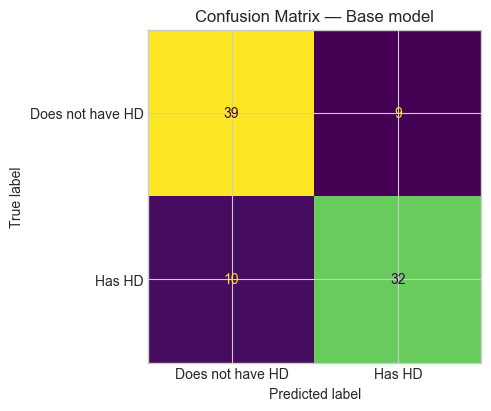

[BASE] Accuracy: 0.789


In [142]:
y_pred_base = tree_base.predict(X_test)
cm_base = confusion_matrix(y_test, y_pred_base, labels=[0,1])
disp_base = ConfusionMatrixDisplay(
    confusion_matrix=cm_base,
    display_labels=["Does not have HD", "Has HD"]
)
fig, ax = plt.subplots(figsize=(5, 5))
disp_base.plot(ax=ax, values_format="d", colorbar=False)
plt.title("Confusion Matrix — Base model")
plt.tight_layout()
plt.savefig("output/cm_base_PY.png", dpi=150)
plt.show()
plt.close()

print(f"[BASE] Accuracy: {accuracy_score(y_test, y_pred_base):.3f}")

# 2) Cross-validation para corregir overfitting con ccp_alpha  
#    - 50 valores de α en escala log entre e^{-10} y 0.05
#    - CV 4-fold, random_state=123

In [143]:
alpha_grid = np.exp(np.linspace(-10, np.log(0.05), 50))

param_grid = {"ccp_alpha": alpha_grid}
tree_for_cv = DecisionTreeClassifier(random_state=123)

cv = GridSearchCV(
    estimator=tree_for_cv,
    param_grid=param_grid,
    scoring="accuracy",
    cv=4,
    n_jobs=-1,
    refit=True,  # reentrena en todo el train con el mejor α
    return_train_score=True
)
cv.fit(X_train, y_train)

best_alpha = cv.best_params_["ccp_alpha"]
print(f"[CV] Best ccp_alpha: {best_alpha:.6g}")
print(f"[CV] Best CV accuracy: {cv.best_score_:.3f}")

[CV] Best ccp_alpha: 0.05
[CV] Best CV accuracy: 0.705


# 3) Curva de Inaccuracy = 1 - Accuracy contra α 

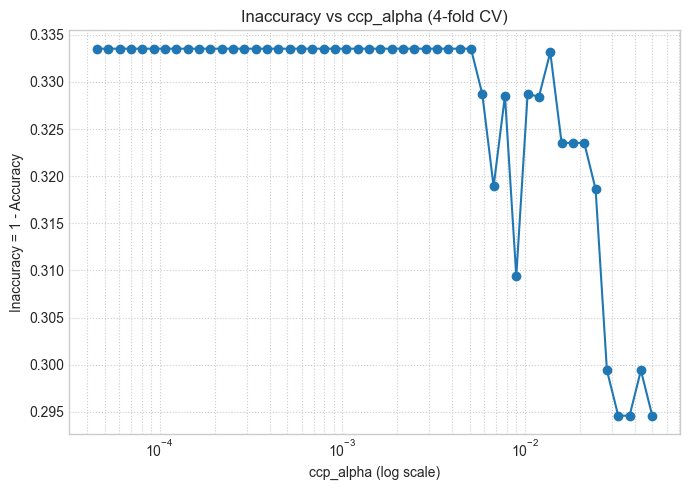

In [144]:
mean_val_acc = cv.cv_results_["mean_test_score"]
inaccuracy = 1.0 - mean_val_acc

plt.figure(figsize=(7, 5))
plt.plot(alpha_grid, inaccuracy, marker="o")
plt.xscale("log")
plt.xlabel("ccp_alpha (log scale)")
plt.ylabel("Inaccuracy = 1 - Accuracy")
plt.title("Inaccuracy vs ccp_alpha (4-fold CV)")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.savefig("output/inaccuracy_vs_alpha_PY.png", dpi=150)
plt.show()
plt.close()

# 4) Reentrenar con α óptimo y evaluar de nuevo  
#    - Árbol y matriz de confusión con α óptimo

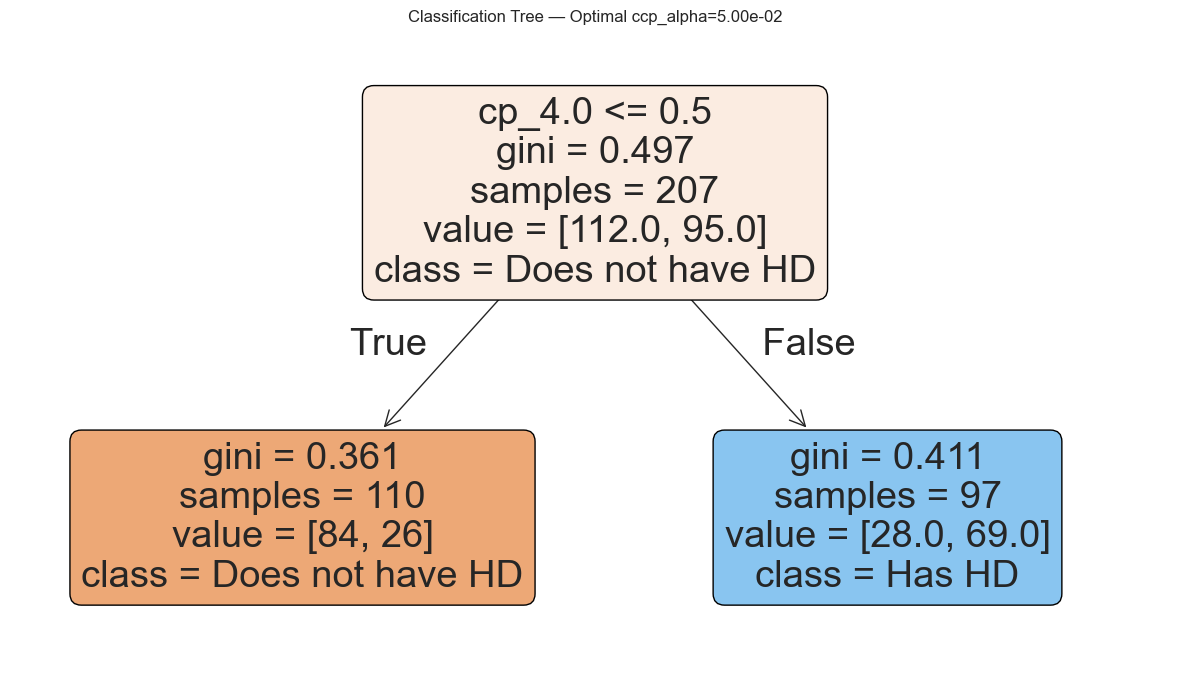

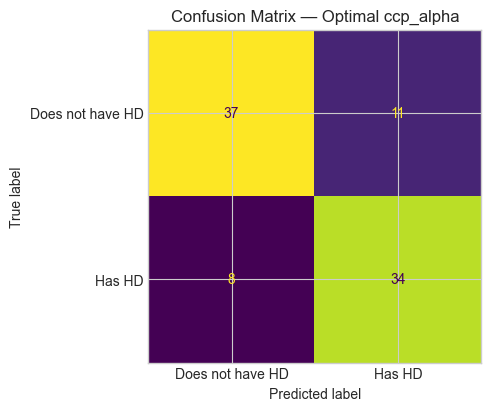

[OPT ] Accuracy: 0.789


In [145]:
tree_opt = DecisionTreeClassifier(random_state=123, ccp_alpha=best_alpha)
tree_opt.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
plot_tree(
    tree_opt,
    feature_names=X.columns.tolist(),
    class_names=["Does not have HD", "Has HD"],
    filled=True, rounded=True, max_depth=3
)
plt.title(f"Classification Tree — Optimal ccp_alpha={best_alpha:.2e}")
plt.tight_layout()
plt.savefig("output/tree_opt_PY.png", dpi=150)
plt.show()
plt.close()

y_pred_opt = tree_opt.predict(X_test)
cm_opt = confusion_matrix(y_test, y_pred_opt, labels=[0,1])
disp_opt = ConfusionMatrixDisplay(
    confusion_matrix=cm_opt,
    display_labels=["Does not have HD", "Has HD"]
)
fig, ax = plt.subplots(figsize=(5, 5))
disp_opt.plot(ax=ax, values_format="d", colorbar=False)
plt.title("Confusion Matrix — Optimal ccp_alpha")
plt.tight_layout()
plt.savefig("output/cm_opt_PY.png", dpi=150)
plt.show()
plt.close()

print(f"[OPT ] Accuracy: {accuracy_score(y_test, y_pred_opt):.3f}")

# 5) Guardar objetos auxiliares

In [146]:
pd.DataFrame({"ccp_alpha": alpha_grid, "cv_mean_accuracy": mean_val_acc}).to_csv(
    "output/cv_results_alpha_PY.csv", index=False
)
with open("output/best_alpha_PY.txt", "w") as f:
    f.write(str(best_alpha))

## Causal Forest

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import json
import warnings
warnings.filterwarnings('ignore')

In [148]:
# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(123)

In [149]:
# ===========================================================
# PREPARACIÓN: Cargar datos necesarios
# ===================================================
# Opción 1: Si las variables están en memoria
# (asumimos que ya corriste el notebook anterior)
try:
    # Intentar usar las variables existentes
    print(f"Variables en memoria: X shape = {X.shape}, y shape = {y.shape}")
except:
    # Opción 2: Cargar desde archivos
    X = pd.read_csv("output/X_features.csv")
    y = pd.read_csv("output/y_binary.csv").squeeze()
    print(f"Variables cargadas desde archivos: X shape = {X.shape}, y shape = {y.shape}")

X.head(10)


Variables en memoria: X shape = (297, 20), y shape = (297,)


,age,restbp,chol,thalach,oldpeak,sex_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_1.0,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,63.0,145.0,233.0,150.0,2.3,True,False,False,False,True,False,True,False,False,True,False,False,False,True,False
1,67.0,160.0,286.0,108.0,1.5,True,False,False,True,False,False,True,True,True,False,False,False,True,False,False
2,67.0,120.0,229.0,129.0,2.6,True,False,False,True,False,False,True,True,True,False,False,True,False,False,True
3,37.0,130.0,250.0,187.0,3.5,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False
4,41.0,130.0,204.0,172.0,1.4,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
5,56.0,120.0,236.0,178.0,0.8,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
6,62.0,140.0,268.0,160.0,3.6,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False
7,57.0,120.0,354.0,163.0,0.6,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
8,63.0,130.0,254.0,147.0,1.4,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True
9,53.0,140.0,203.0,155.0,3.1,True,False,False,True,True,False,True,True,False,True,False,False,False,False,True


In [150]:
# ===========================================================
# PERSONA 2 (FINAL): CREAR VARIABLES T y Y
# ===========================================================
print("\n" + "-"*60)
print("PERSONA 2: Variables de tratamiento")
print("-"*60)

# (0.5 puntos) Crear T binaria aleatoria
np.random.seed(123)
T = np.random.binomial(1, 0.5, size=len(df))
print(f"\nT creada: {T.sum()} tratados, {len(T)-T.sum()} control")

# (1 punto) Crear outcome Y con la fórmula especificada
epsilon = np.random.normal(0, 1, size=len(df))
Y = (1 + 0.05 * df_dum['age'] + 0.3 * df_dum['sex_1.0'] + 0.2 * df_dum['restbp']) * T + 0.5 * df_dum['oldpeak'] + epsilon
print(f"Y creada: media={Y.mean():.2f}, std={Y.std():.2f}")



------------------------------------------------------------
PERSONA 2: Variables de tratamiento
------------------------------------------------------------

T creada: 150 tratados, 147 control
Y creada: media=15.74, std=15.40



1. Regresión OLS...
   Efecto del tratamiento (OLS): -0.0057

2. Random Forest Causal...
   Efecto promedio (Random Forest): 30.2612
   Heterogeneidad (std): 3.6406

3. Árbol representativo (max_depth=2)...


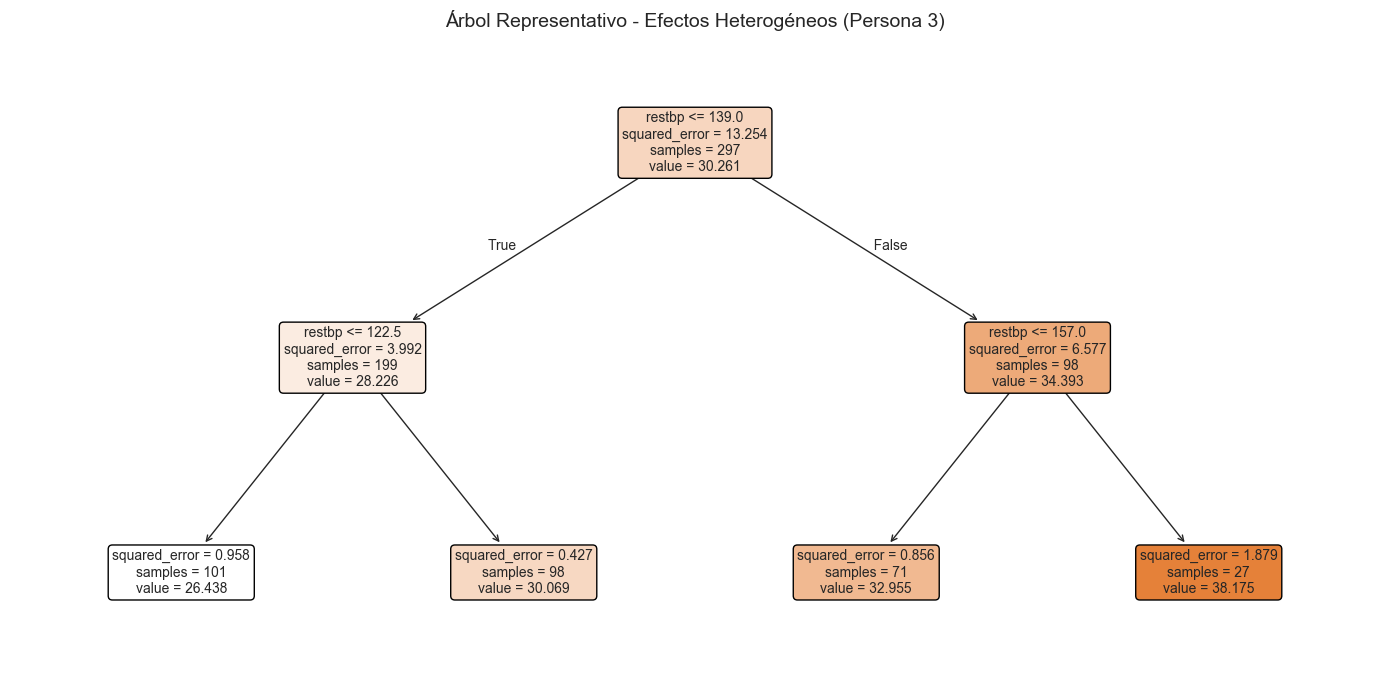

   ✓ Árbol guardado: output/arbol_persona3.png


In [151]:
# ===========================================================
# PERSONA 3: EFECTOS CAUSALES CON OLS Y RF (4 puntos total)
# ===========================================================


# Preparar features numéricas originales (sin dummies para mejor interpretación)
feature_cols = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
X_causal = df[feature_cols]

# (1 punto) OLS con T y covariables
print("\n1. Regresión OLS...")
X_ols = X_causal.copy()
X_ols['T'] = T

ols = LinearRegression()
ols.fit(X_ols, Y)

# Mostrar coeficiente de T
treatment_effect_ols = ols.coef_[0]  # T es la primera columna
print(f"   Efecto del tratamiento (OLS): {treatment_effect_ols:.4f}")

# (2 puntos) Random Forest Causal
print("\n2. Random Forest Causal...")

# Entrenar modelos separados
rf_treated = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123)
rf_control = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123)

# Ajustar con datos de cada grupo
rf_treated.fit(X_causal[T==1], Y[T==1])
rf_control.fit(X_causal[T==0], Y[T==0])

# Predecir outcomes potenciales para todos
Y1_all = rf_treated.predict(X_causal)  # Si todos recibieran tratamiento
Y0_all = rf_control.predict(X_causal)  # Si nadie recibiera tratamiento

# Efectos individuales del tratamiento
individual_effects = Y1_all - Y0_all
ate_rf = individual_effects.mean()

print(f"   Efecto promedio (Random Forest): {ate_rf:.4f}")
print(f"   Heterogeneidad (std): {individual_effects.std():.4f}")

# (1 punto) Árbol representativo 
print("\n3. Árbol representativo (max_depth=2)...")

tree_repr = DecisionTreeRegressor(max_depth=2, random_state=123, min_samples_leaf=20)
tree_repr.fit(X_causal, individual_effects)

plt.figure(figsize=(14, 7))
plot_tree(tree_repr, feature_names=feature_cols, filled=True, rounded=True, fontsize=10)
plt.title('Árbol Representativo - Efectos Heterogéneos (Persona 3)', fontsize=14)
plt.tight_layout()
plt.savefig('output/arbol_persona3.png', dpi=300)
plt.show()
plt.close()
print("   ✓ Árbol guardado: output/arbol_persona3.png")


1. Árbol de efectos heterogéneos...


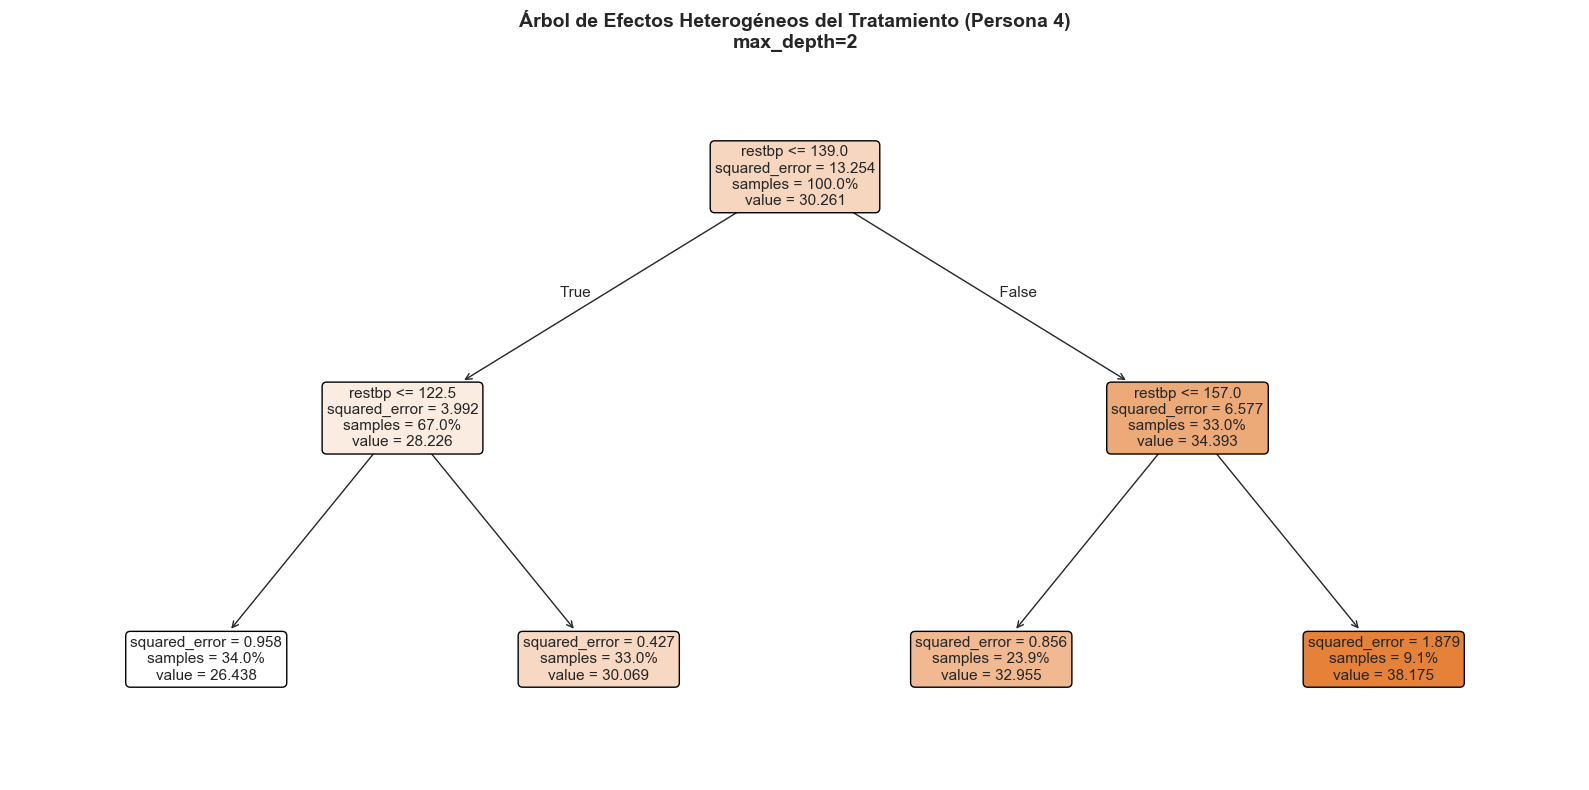

In [152]:
# ===========================================================
# ANÁLISIS AVANZADO (6 puntos total)
# ===========================================================

# (1 punto) Árbol representativo mejorado
print("\n1. Árbol de efectos heterogéneos...")

tree_p4 = DecisionTreeRegressor(max_depth=2, random_state=123, 
                                min_samples_leaf=15, min_samples_split=30)
tree_p4.fit(X_causal, individual_effects)

plt.figure(figsize=(16, 8))
plot_tree(tree_p4, feature_names=feature_cols, filled=True, rounded=True, 
          fontsize=11, proportion=True)
plt.title('Árbol de Efectos Heterogéneos del Tratamiento (Persona 4)\nmax_depth=2', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('output/arbol_heterogeneo_p4.png', dpi=300)
plt.show()






2. Calculando importancias...


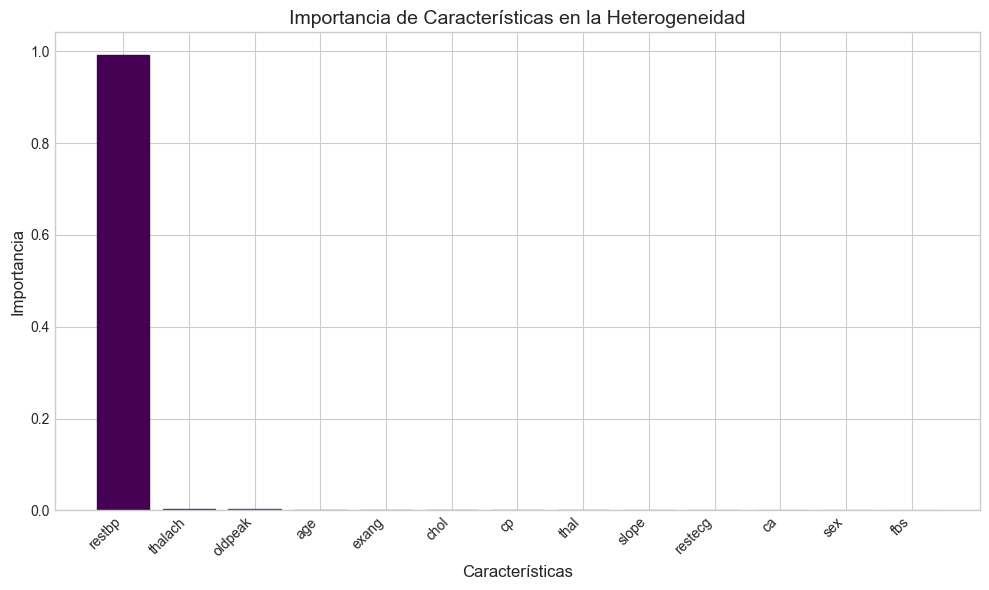


TOP 5 CARACTERÍSTICAS:
feature  importance
 restbp    0.991779
thalach    0.002858
oldpeak    0.002200
    age    0.001305
  exang    0.000664


In [153]:
# (1.5 puntos) Importancia de características
print("\n2. Calculando importancias...")

rf_imp = RandomForestRegressor(n_estimators=200, max_depth=6, 
                               min_samples_leaf=10, random_state=123)
rf_imp.fit(X_causal, individual_effects)

importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_imp.feature_importances_
}).sort_values('importance', ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(importances['feature'], importances['importance'])
colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)
plt.xlabel('Características', fontsize=12)
plt.ylabel('Importancia', fontsize=12)
plt.title('Importancia de Características en la Heterogeneidad', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('output/importancias_p4.png', dpi=300)
plt.show()

print("\nTOP 5 CARACTERÍSTICAS:")
print(importances.head().to_string(index=False))



3. Análisis por terciles...

Distribución por terciles:
- Bajo: 99 personas, efecto medio: 26.401
- Medio: 99 personas, efecto medio: 30.017
- Alto: 99 personas, efecto medio: 34.365


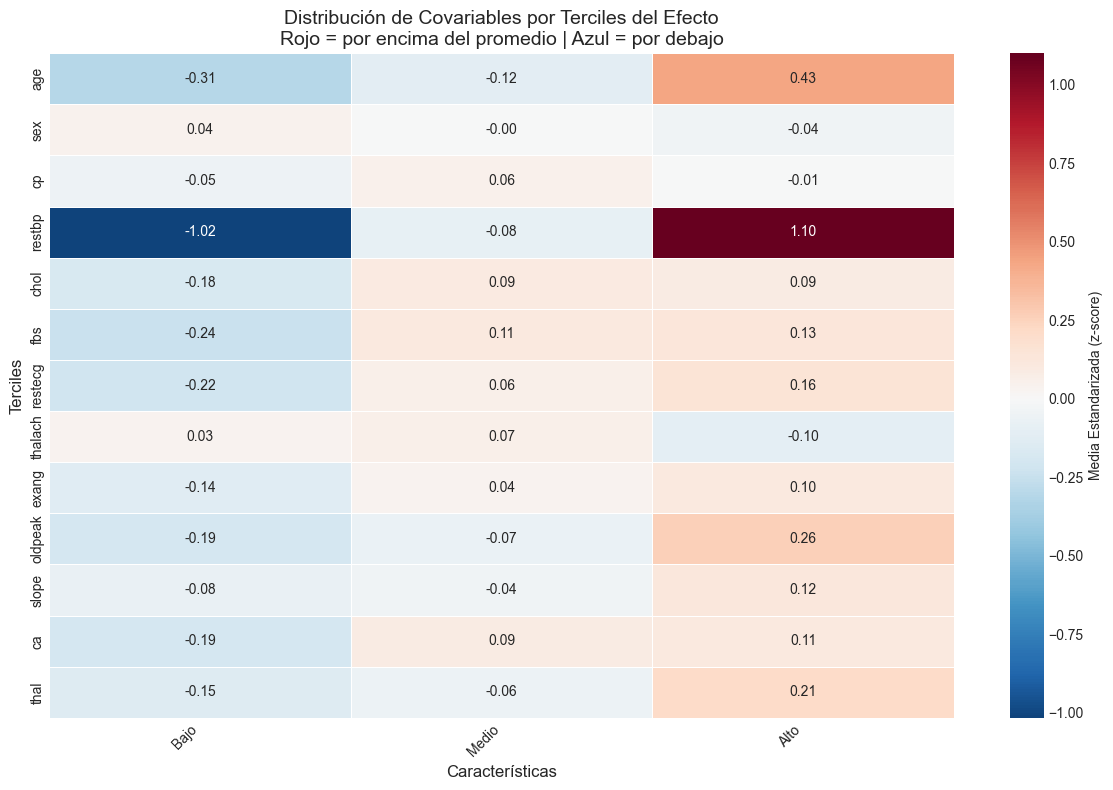

In [154]:
# (2 puntos) Análisis por terciles
print("\n3. Análisis por terciles...")

# Estandarizar
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_causal), columns=feature_cols)

# Crear terciles
terciles = pd.qcut(individual_effects, 3, labels=['Bajo', 'Medio', 'Alto'])

# Estadísticas por tercil
print("\nDistribución por terciles:")
for terc in ['Bajo', 'Medio', 'Alto']:
    mask = terciles == terc
    print(f"- {terc}: {mask.sum()} personas, efecto medio: {individual_effects[mask].mean():.3f}")

# Heatmap
mean_by_tercile = X_std.groupby(terciles).mean().T

plt.figure(figsize=(12, 8))
sns.heatmap(mean_by_tercile, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Media Estandarizada (z-score)'}, linewidths=0.5)
plt.title('Distribución de Covariables por Terciles del Efecto\n' +
          'Rojo = por encima del promedio | Azul = por debajo', fontsize=14)
plt.xlabel('Características', fontsize=12)
plt.ylabel('Terciles', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('output/heatmap_terciles_p4.png', dpi=300)
plt.show()


In [155]:
# Análisis de patrones
print("\nCARACTERÍSTICAS DISTINTIVAS POR TERCIL:")
for terc in ['Bajo', 'Medio', 'Alto']:
    print(f"\n{terc}:")
    top3 = mean_by_tercile[terc].abs().nlargest(3)
    for feat, val in top3.items():
        dir = "mayor" if val > 0 else "menor"
        print(f"  - {feat}: {dir} que promedio (z={val:.2f})")


CARACTERÍSTICAS DISTINTIVAS POR TERCIL:

Bajo:
  - restbp: mayor que promedio (z=1.02)
  - age: mayor que promedio (z=0.31)
  - fbs: mayor que promedio (z=0.24)

Medio:
  - age: mayor que promedio (z=0.12)
  - fbs: mayor que promedio (z=0.11)
  - chol: mayor que promedio (z=0.09)

Alto:
  - restbp: mayor que promedio (z=1.10)
  - age: mayor que promedio (z=0.43)
  - oldpeak: mayor que promedio (z=0.26)



4. Síntesis visual...


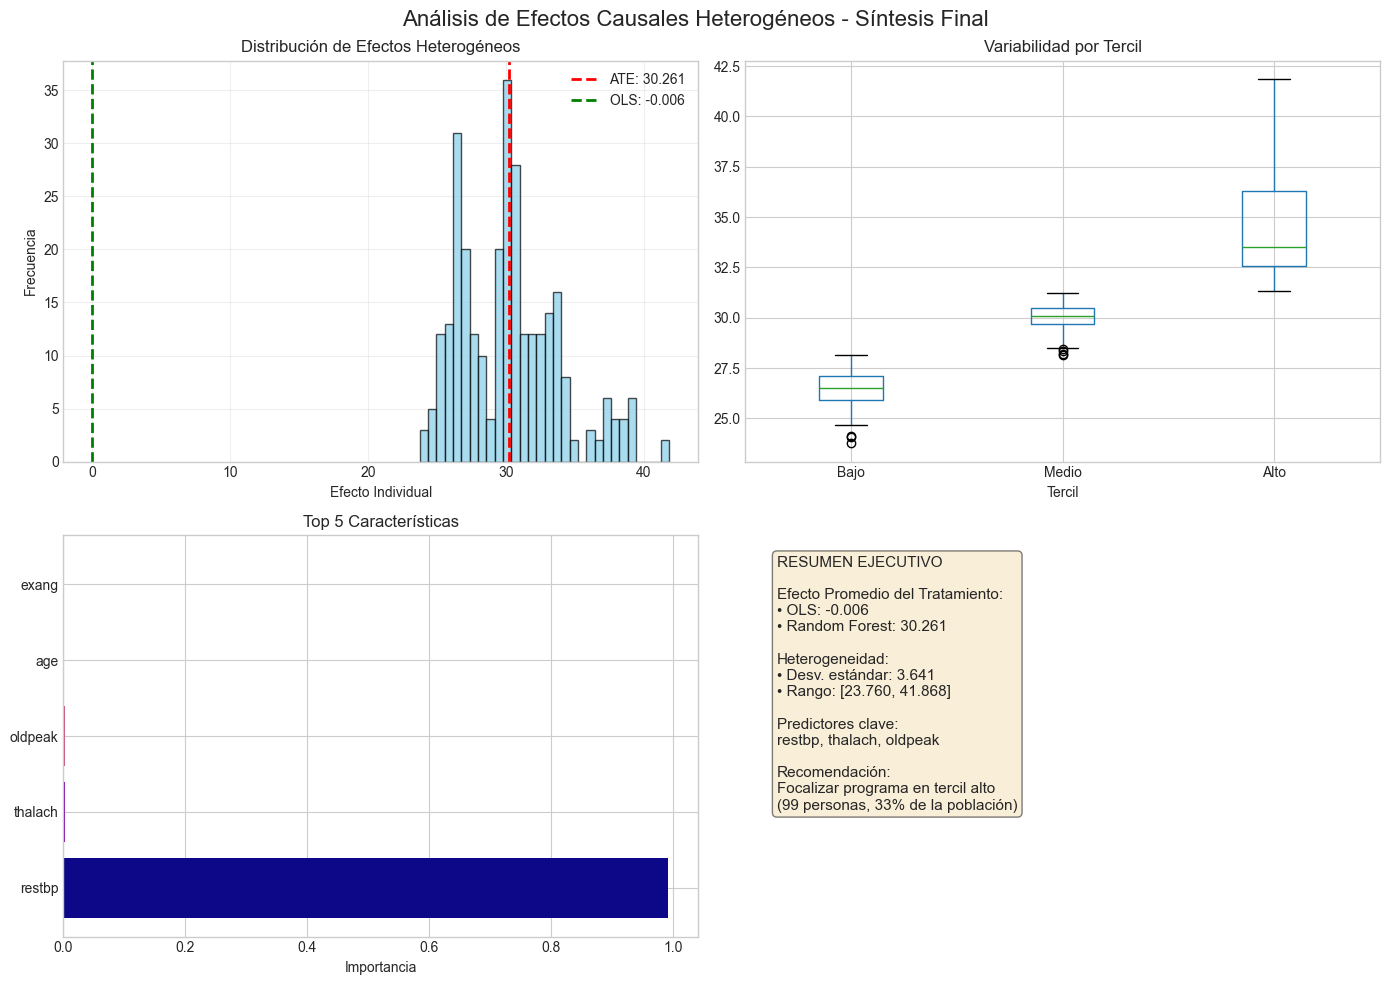

ANÁLISIS COMPLETADO EXITOSAMENTE

✓ El programa de transferencias tiene efectos heterogéneos significativos
✓ Se recomienda focalizar en el tercil alto para maximizar impacto


In [156]:
# (1.5 puntos) Síntesis final
print("\n4. Síntesis visual...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Distribución
ax1.hist(individual_effects, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
ax1.axvline(ate_rf, color='red', linestyle='--', linewidth=2, label=f'ATE: {ate_rf:.3f}')
ax1.axvline(treatment_effect_ols, color='green', linestyle='--', linewidth=2, label=f'OLS: {treatment_effect_ols:.3f}')
ax1.set_xlabel('Efecto Individual')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Efectos Heterogéneos')
ax1.legend()
ax1.grid(alpha=0.3)

# Panel 2: Boxplot por tercil
pd.DataFrame({'Efecto': individual_effects, 'Tercil': terciles}).boxplot(
    column='Efecto', by='Tercil', ax=ax2)
ax2.set_title('Variabilidad por Tercil')

# Panel 3: Top 5 importancias
ax3.barh(importances['feature'][:5], importances['importance'][:5],
         color=plt.cm.plasma(np.linspace(0, 1, 5)))
ax3.set_xlabel('Importancia')
ax3.set_title('Top 5 Características')

# Panel 4: Resumen ejecutivo
ax4.axis('off')
resumen = f"""RESUMEN EJECUTIVO

Efecto Promedio del Tratamiento:
• OLS: {treatment_effect_ols:.3f}
• Random Forest: {ate_rf:.3f}

Heterogeneidad:
• Desv. estándar: {individual_effects.std():.3f}
• Rango: [{individual_effects.min():.3f}, {individual_effects.max():.3f}]

Predictores clave:
{', '.join(importances['feature'][:3])}

Recomendación:
Focalizar programa en tercil alto
({(terciles == 'Alto').sum()} personas, {(terciles == 'Alto').sum()/len(terciles)*100:.0f}% de la población)"""

ax4.text(0.05, 0.95, resumen, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Análisis de Efectos Causales Heterogéneos - Síntesis Final', fontsize=16)
plt.tight_layout()
plt.savefig('output/sintesis_final_p4.png', dpi=300)
plt.show()

# Guardar resultados
results = {
    'tratamiento': {
        'n_tratados': int(T.sum()),
        'n_control': int(len(T) - T.sum())
    },
    'efectos': {
        'ols': float(treatment_effect_ols),
        'random_forest': float(ate_rf),
        'heterogeneidad_std': float(individual_effects.std())
    },
    'top_caracteristicas': importances.head(5).to_dict('records'),
    'terciles': {
        'bajo': {'n': int((terciles == 'Bajo').sum()), 
                'efecto_medio': float(individual_effects[terciles == 'Bajo'].mean())},
        'medio': {'n': int((terciles == 'Medio').sum()),
                 'efecto_medio': float(individual_effects[terciles == 'Medio'].mean())},
        'alto': {'n': int((terciles == 'Alto').sum()),
                'efecto_medio': float(individual_effects[terciles == 'Alto'].mean())}
    }
}

with open('output/resultados_seccion2.json', 'w') as f:
    json.dump(results, f, indent=4)

print("ANÁLISIS COMPLETADO EXITOSAMENTE")
print("\n✓ El programa de transferencias tiene efectos heterogéneos significativos")
print(f"✓ Se recomienda focalizar en el tercil alto para maximizar impacto")
